In [101]:
# import modules
import numpy as np  # linear algebra
import pandas as pd  # dataframe
from datetime import datetime

# stats modules
from scipy.stats import skew, norm, boxcox_normmax 
from scipy.special import boxcox1p #box-cox transformation

# ML modules
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_selection import SelectFromModel, RFECV
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, RandomForestClassifier
from sklearn.svm import SVR, LinearSVC
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import RobustScaler, LabelBinarizer, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, MinMaxScaler, scale
from mlxtend.regressor import StackingCVRegressor
from sklearn.kernel_ridge import KernelRidge
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import lightgbm as lgb
from mlxtend.regressor import StackingRegressor
from catboost import CatBoostRegressor, Pool

import os

# plot modules
from matplotlib import pyplot as plt
import seaborn as sns

# Data Processing

## Load Data

In [2]:
file_name = 'housing.csv'
housing_df = pd.read_csv(file_name)

In [3]:
housing_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
housing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [5]:
housing_df['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [6]:
housing_df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000029FBB2E12E8>,
      dtype=object)

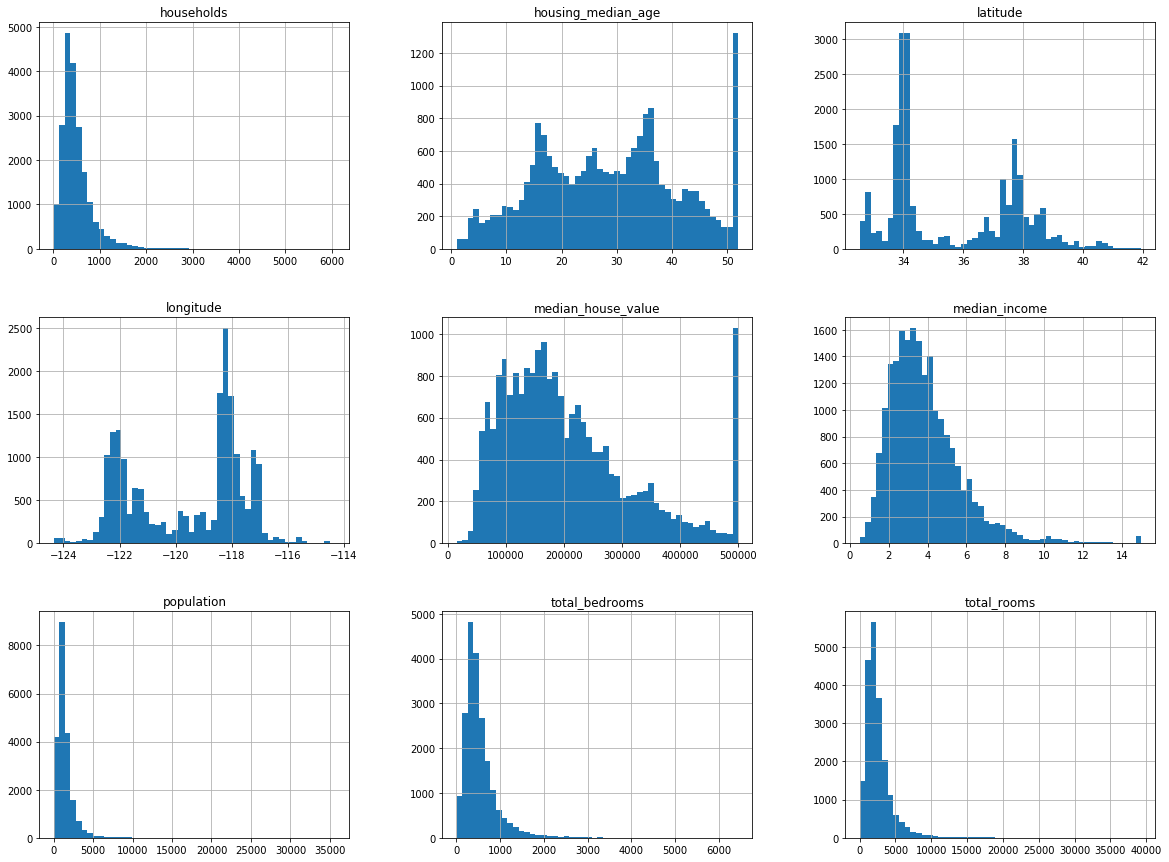

In [7]:
housing_df.hist(bins=50, figsize=(20,15))

In [12]:
# random sampling
train_set, test_set = train_test_split(housing_df, test_size = 0.2, random_state = 0)

In [19]:
# stratified sampling: the population is divided into homogeneous subgroups called strata,
# and the right number of instances is sampled from each stratum to guarantee that 
# the test set is representative of the overall population.

# create an income category attribute by dividing the median income by 1.5(to limit the number of income categories)
# and rounding up using ceil and merging all the categories greater than 5 into 5

housing_df['income_cat'] = np.ceil(housing_df['median_income']/1.5)
housing_df['income_cat'].where(housing_df['income_cat'] < 5, 5.0, inplace=True)

In [20]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
for train_index, test_index in split.split(housing_df, housing_df['income_cat']):
    print("TRAIN:", train_index, "TEST:", test_index)
    strat_train_set = housing_df.loc[train_index,:]
    strat_test_set = housing_df.loc[test_index,:]

TRAIN: [10275 20601 20138 ...  3407 17590  4303] TEST: [ 5784   378 11018 ...  3749 15989  2154]


In [21]:
housing_df['income_cat'].value_counts() / len(housing_df)

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64

In [22]:
strat_train_set['income_cat'].value_counts() / len(strat_train_set)

3.0    0.350594
2.0    0.318859
4.0    0.176296
5.0    0.114402
1.0    0.039850
Name: income_cat, dtype: float64

In [23]:
strat_test_set['income_cat'].value_counts() / len(strat_test_set)

3.0    0.350533
2.0    0.318798
4.0    0.176357
5.0    0.114583
1.0    0.039729
Name: income_cat, dtype: float64

In [24]:
strat_train_set.drop('income_cat', axis=1, inplace=True)
strat_test_set.drop('income_cat', axis=1, inplace=True)

# Discover and Visualize the Data to Gain Insights

In [25]:
housing = strat_train_set.copy()

## Visualizing Geographical Data

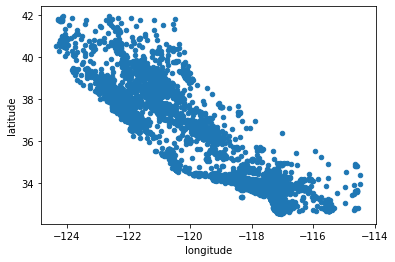

In [26]:
housing.plot(kind='scatter', x='longitude', y='latitude')

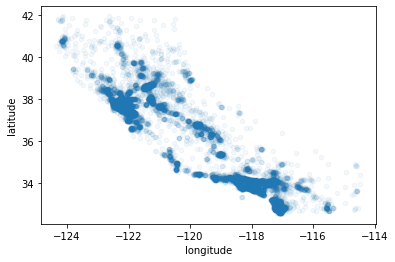

In [29]:
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.05)

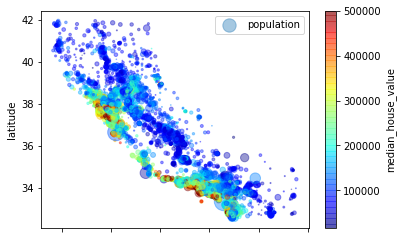

In [31]:
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.4,
             s=housing['population']/100, label='population',
             c='median_house_value', cmap=plt.get_cmap('jet'), colorbar=True)

# s: The marker size in points**2
# c: The marker color

## Looking for Correlations

In [32]:
corr_matrix = housing.corr()

In [33]:
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688883
total_rooms           0.137469
housing_median_age    0.107144
households            0.069177
total_bedrooms        0.053544
population           -0.023797
longitude            -0.043236
latitude             -0.145570
Name: median_house_value, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000029FC99B3B70>,
      dtype=object)

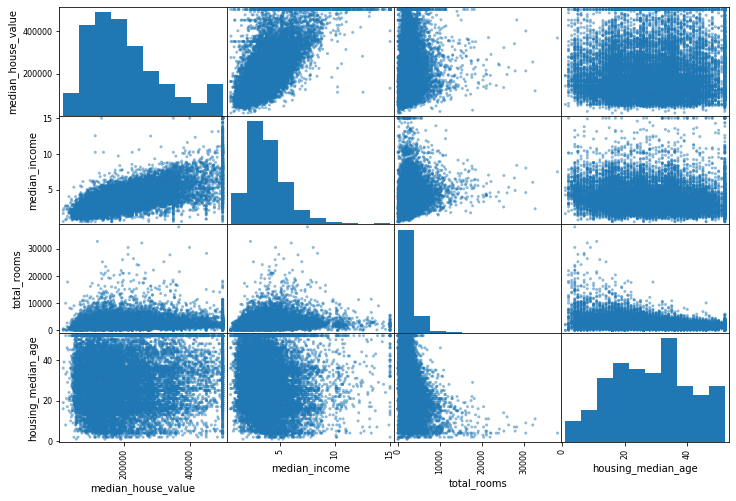

In [38]:
attributes = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']
from pandas.plotting import scatter_matrix
scatter_matrix(housing[attributes],figsize=(12,8))

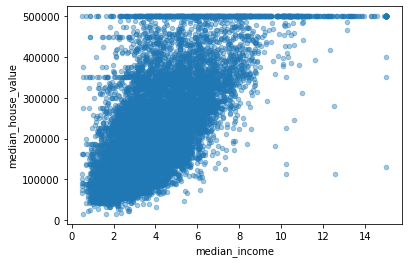

In [44]:
housing.plot(kind='scatter', x='median_income', y='median_house_value', alpha=0.4)

## Experimenting with Attribute Combinations

In [41]:
housing['rooms_per_household'] = housing['total_rooms'] / housing['households']
housing['beadrooms_per_room'] = housing['total_bedrooms'] / housing['total_rooms']
housing['population_per_household'] = housing['population'] / housing['households']

In [43]:
housing.corr()['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.688883
rooms_per_household         0.157620
total_rooms                 0.137469
housing_median_age          0.107144
households                  0.069177
total_bedrooms              0.053544
population                 -0.023797
population_per_household   -0.026888
longitude                  -0.043236
latitude                   -0.145570
beadrooms_per_room         -0.255870
Name: median_house_value, dtype: float64

In [45]:
housing = strat_train_set.drop('median_house_value', axis=1)
housing_label = strat_train_set['median_house_value'].copy()

### Data Cleaning

#### 1.  Missing Value Imputation

In [49]:
imputer = SimpleImputer(strategy='median')
housing_num = housing.drop("ocean_proximity", axis=1)
imputer.fit(housing_num)
imputer.statistics_

array([-118.49  ,   34.25  ,   29.    , 2128.5   ,  436.    , 1167.    ,
        410.    ,    3.5341])

In [50]:
X = imputer.transform(housing_num)

In [51]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns)

#### 2. Custom Transformers

In [52]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, household_ix = 3,4,5,6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self # do nothing
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]
attr_adder = CombinedAttributesAdder(False)
housing_extra_attribs = attr_adder.transform(housing.values)
    

### Data Transformation Pipeline

In [56]:
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler())
])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [62]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [73]:
# A full pipeline handling both numerical and categorical attributes

num_attribs = list(housing_num)
cat_attribs = ['ocean_proximity']

num_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_attribs)),
    ('imputer', SimpleImputer(strategy='median')),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(cat_attribs)),
    ('one_hot_encoder', OneHotEncoder(sparse=False))
])

full_pipeline = FeatureUnion(transformer_list = [
    ('num_pipeline', num_pipeline),
    ('cat_pipeline', cat_pipeline)
])

In [74]:
housing_prepared = full_pipeline.fit_transform(housing)

In [75]:
housing_prepared.shape

(16512, 16)

# Select and Train a Model

## Training and Evaluating on the Training Set

### Linear Regression

In [78]:
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_label)
housing_prediction = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_label, housing_prediction)
# RMSE
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68284.24083518104

### Decision Tree Regression

In [81]:
tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_label)
tree_prediction = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_label, tree_prediction)
tree_rmse = np.sqrt(tree_mse)
tree_mse

0.0

### Cross Validation

In [87]:
scores = cross_val_score(tree_reg, housing_prepared, housing_label,
                        scoring='neg_mean_squared_error', cv=10)
rmse_scores = np.sqrt(-scores)
rmse_scores

array([72392.40738933, 71494.14159048, 70211.4375389 , 69344.46779996,
       69518.69365386, 71459.44155228, 74581.14910848, 73309.34932884,
       66645.83699231, 70273.48484401])

In [89]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_label,
                            scoring='neg_mean_squared_error', cv=10)
rmse_scores = np.sqrt(-lin_scores)
print(rmse_scores.mean())
print(rmse_scores.std())

68480.72928763037
1456.3942894476645


### Random Forest Regression

In [90]:
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_label)
forest_prediction = forest_reg.predict(housing_prepared)
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_label,
                            scoring='neg_mean_squared_error', cv=10)
rmse_scores = np.sqrt(-forest_scores)
print(rmse_scores.mean())
print(rmse_scores.std())

c:\users\sunx\appdata\local\programs\python\python37\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


52940.68009934224
1704.4641688452143


## Model Fine-Tuning

### Grid Search

In [93]:
param_grid = [{'n_estimators': [3, 10, 30],
               'max_features': [2, 4, 6, 8]},
              {'n_estimators': [3, 10],
               'max_features': [2, 3, 4],
               'bootstrap':[False]}]

grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(housing_prepared, housing_label)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=10, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid=[{'max_features': [2, 4, 6, 8],
    

In [94]:
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

In [95]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features=6, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=30,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [99]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)

64192.81419841772 {'max_features': 2, 'n_estimators': 3}
55213.34186754801 {'max_features': 2, 'n_estimators': 10}
52814.020805782144 {'max_features': 2, 'n_estimators': 30}
59698.95582399058 {'max_features': 4, 'n_estimators': 3}
52798.94382564309 {'max_features': 4, 'n_estimators': 10}
50605.3349607 {'max_features': 4, 'n_estimators': 30}
58803.427937533655 {'max_features': 6, 'n_estimators': 3}
51598.08582325465 {'max_features': 6, 'n_estimators': 10}
50271.59542542411 {'max_features': 6, 'n_estimators': 30}
58937.92108234232 {'max_features': 8, 'n_estimators': 3}
52317.455312714395 {'max_features': 8, 'n_estimators': 10}
50364.41345574295 {'max_features': 8, 'n_estimators': 30}
62203.79555877518 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
55042.673354785904 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
60040.251836982854 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52298.41579249691 {'bootstrap': False, 'max_features': 3, 'n_estimators': 1

### Random Search

In [103]:
param_grid = {'n_estimators': [3, 10, 30],
               'max_features': [2, 4, 6, 8]}

random_search = RandomizedSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error')
random_search.fit(housing_prepared, housing_label)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=10, n_jobs=None,
                                                   oob_score=False,
                                                   random_state=None,

In [110]:
extra_attribs = ['rooms_per_hhold', 'pop_per_hhold', 'bedrooms_per_room']
cat_one_hot_attribs = list(pd.get_dummies(housing['ocean_proximity']).columns)
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
pd.DataFrame({'Attributes': attributes, 'FeatureScore': random_search.best_estimator_.feature_importances_}).sort_values(by='FeatureScore',ascending=False)

,Attributes,FeatureScore
7,median_income,0.399776
12,INLAND,0.156904
9,pop_per_hhold,0.107111
0,longitude,0.068588
1,latitude,0.059964
8,rooms_per_hhold,0.051696
10,bedrooms_per_room,0.042921
2,housing_median_age,0.041280
3,total_rooms,0.016416
4,total_bedrooms,0.015658


## Evaluate the Model on the Test Set

In [111]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop('median_house_value', axis=1)
y_test = strat_test_set['median_house_value'].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

47948.0896226348